In [110]:
#We will import the necessary Library
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

# For data visulization we will use these library
import matplotlib.pyplot as plt
from itertools import cycle
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# For the model building, we will use these following libraries
import pmdarima as pm
import xgboost as xgb

from xgboost import plot_importance, plot_tree
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, model_selection, feature_selection, linear_model, ensemble, metrics
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import KBinsDiscretizer

# For the model evaluation, we will use the following libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [111]:
train = pd.read_csv("train_data.csv")
train.head()

,date,ts,wp,hi,lo,open
0,2017-02-25,1.487981e+09,1172.382511,1189.49,1110.00,1186.91
1,2017-12-28,1.514419e+09,14292.860031,15489.00,13500.00,15360.01
2,2016-08-05,1.470355e+09,579.201128,592.87,570.39,587.50
3,2015-11-21,1.448064e+09,324.774137,328.00,316.33,322.39
4,2015-11-26,1.448496e+09,342.988280,368.18,328.98,328.99


In [112]:
test = pd.read_csv("test_data.csv")
test.head()

,date,ts,wp,hi,lo,open
0,2016-07-16,1.468627e+09,667.010196,669.99,662.01,667.48
1,2016-09-20,1.474330e+09,608.817753,609.92,605.60,608.60
2,2017-02-27,1.488154e+09,1189.531393,1198.99,1176.00,1184.91
3,2016-10-08,1.475885e+09,618.950957,620.00,617.55,618.11
4,2015-12-08,1.449533e+09,395.036331,418.94,386.69,394.73


In [113]:
label = pd.read_csv("train_label.csv")
label.head()

,date,close
0,2017-02-25,1158.00
1,2017-12-28,14450.01
2,2016-08-05,583.00
3,2015-11-21,327.00
4,2015-11-26,352.57


In [114]:
train.select_dtypes(exclude=['float64', 'int64']).head(5)

,date
0,2017-02-25
1,2017-12-28
2,2016-08-05
3,2015-11-21
4,2015-11-26


We will merge the dataframes of `train` and `label` to include the closing price in our dataset.

In [115]:
train['close'] = label['close']
data = train.copy()
data.head()

,date,ts,wp,hi,lo,open,close
0,2017-02-25,1.487981e+09,1172.382511,1189.49,1110.00,1186.91,1158.00
1,2017-12-28,1.514419e+09,14292.860031,15489.00,13500.00,15360.01,14450.01
2,2016-08-05,1.470355e+09,579.201128,592.87,570.39,587.50,583.00
3,2015-11-21,1.448064e+09,324.774137,328.00,316.33,322.39,327.00
4,2015-11-26,1.448496e+09,342.988280,368.18,328.98,328.99,352.57


So, we need to transform `date` from categorical data to `date time object`. We can see that the data present in the dataset is not serially organised by `date`. So, we will convert the values to datetime values.
Then we will organize the dataset as per the date.

In [116]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.sort_values(by="date")
data

,date,ts,wp,hi,lo,open,close
696,2015-04-15,1.429056e+09,222.270771,224.52,218.09,221.05,224.35
185,2015-04-16,1.429142e+09,227.779413,230.75,223.66,224.35,229.45
287,2015-04-18,1.429315e+09,223.398170,224.04,222.18,223.55,224.02
647,2015-04-19,1.429402e+09,224.667792,226.72,223.44,224.02,224.03
280,2015-04-21,1.429574e+09,227.170562,235.89,224.01,225.35,235.89
...,...,...,...,...,...,...,...
739,2017-12-31,1.514678e+09,13386.497711,14280.26,12633.80,12839.98,13863.13
571,2018-01-01,1.514765e+09,13425.054178,13889.00,12952.50,13863.14,13480.01
450,2018-01-03,1.514938e+09,14989.939350,15400.00,14628.00,14781.52,15098.14
367,2018-01-04,1.515024e+09,14851.477880,15400.00,14230.00,15098.23,15144.99


In [10]:
print("The total number of days present in the training dataset:", train.shape[0])
print("The total number of days present in the test dataset:", test.shape[0])

The total number of days present in the training dataset: 749
The total number of days present in the test dataset: 250


In [11]:
print("The total number of features present in the training dataset:", train.shape[1])
print("The total number of features present in the test dataset:", test.shape[1])

The total number of features present in the training dataset: 7
The total number of features present in the test dataset: 6


In [12]:
train.shape

(749, 7)

In [13]:
train.tail()

,date,ts,wp,hi,lo,open,close
744,2016-01-29,1.454026e+09,376.906500,385.05,363.25,379.63,378.68
745,2015-08-02,1.438474e+09,280.488208,282.62,277.33,281.90,282.62
746,2017-10-08,1.507421e+09,4501.692441,4612.00,4420.01,4425.00,4603.49
747,2016-08-07,1.470528e+09,594.310253,598.65,587.20,591.70,595.14
748,2017-03-03,1.488499e+09,1278.979821,1294.99,1255.61,1269.17,1292.86


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 749 entries, 0 to 748
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    749 non-null    object 
 1   ts      749 non-null    float64
 2   wp      749 non-null    float64
 3   hi      749 non-null    float64
 4   lo      749 non-null    float64
 5   open    749 non-null    float64
 6   close   749 non-null    float64
dtypes: float64(6), object(1)
memory usage: 41.1+ KB


In [15]:
train.describe()

,ts,wp,hi,lo,open,close
count,7.490000e+02,749.000000,749.000000,749.000000,749.000000,749.000000
mean,1.471884e+09,1854.409664,1926.637997,1771.344272,1849.668064,1863.341736
std,2.514630e+07,3203.809842,3380.355015,3006.303192,3205.428177,3226.885876
min,1.429056e+09,215.969046,224.040000,198.020000,211.160000,211.160000
25%,1.449187e+09,375.421207,382.050000,363.580000,374.260000,373.830000
50%,1.471824e+09,629.745037,636.990000,615.460000,622.070000,629.790000
75%,1.493942e+09,1583.432921,1618.310000,1535.110000,1551.300000,1563.390000
max,1.515283e+09,19537.276941,19891.990000,19010.000000,19650.020000,19378.990000


# Checking for `Null` Values

In [16]:
print("The Null Values present in the dataset:", data.isnull().values.sum())

The Null Values present in the dataset: 0


In [17]:
print("The NA values present in the dataset:", data.isnull().values.any())

The NA values present in the dataset: False


If the dataset has any `NULL` values or `NA` values, then we can use the following code to remove all those values present in the dataset.

In [18]:
# data=data.dropna()
# print("The Null Values present in the dataset:", data.isnull().values.sum())
# print("The NA values present in the dataset:", data.isnull().values.any())

In [19]:
# Final shape of the dataset after the removal of NULL and NA values.
data.shape

(749, 7)

## Data Analysis and Visualization

In [20]:
print("Starting Date and Time", data['date'].iloc[0])
print("Ending Date and Time:", data['date'].iloc[-1])

Starting Date and Time 2015-04-15 00:00:00
Ending Date and Time: 2018-01-07 00:00:00


#### Taking only 2017 bitocoin `open` and `close` price for analysis and visualization

In [21]:
data_2017 = data.loc[(data['date'] >= '2017-01-01') & (data['date'] <= '2017-12-31')]

In [22]:
monthwise= data_2017.groupby(data_2017['date'].dt.strftime('%B'))[['open','close']].max()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthwise = monthwise.reindex(new_order, axis=0)
monthwise

,open,close
date,,
January,1131.10,1130.30
February,1195.84,1195.08
March,1293.06,1292.86
April,1352.96,1365.43
May,2362.17,2303.29
June,2871.29,2931.15
July,2873.45,2873.48
August,4599.01,4743.94
September,4948.00,4947.99


In [23]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthwise.index,
    y=monthwise['open'],
    name='Bitcoin Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthwise.index,
    y=monthwise['close'],
    name='Bitcoin Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, title='Monthwise comparision between Bitcoin open and close price in 2017')
fig.show()

In [24]:
data_2017.groupby(data_2017['date'].dt.strftime('%B'))['lo'].min()
monthvise_high = data_2017.groupby(data['date'].dt.strftime('%B'))['hi'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = data_2017.groupby(data_2017['date'].dt.strftime('%B'))['lo'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Bitcoin high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Bitcoin low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', title=' Monthwise High and Low Bitcoin price in 2017')
fig.show()

In [25]:
names = cycle(['Bitcoin Open Price','Bitcoin Close Price','Bitcoin High Price','Bitcoin Low Price'])

fig = px.line(data_2017, x=data_2017.date, y=[data_2017['open'], 
                    data_2017['close'], data_2017['hi'], data_2017['lo']], 
                    labels={'Date': 'Date','value':'Bitcoin value'})
fig.update_layout(title_text='Bitcoin price analysis chart year 2017', font_size=15, font_color='black',legend_title_text='Bitcoin Parameters')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

#### Overall Bitcoin Price Analysis

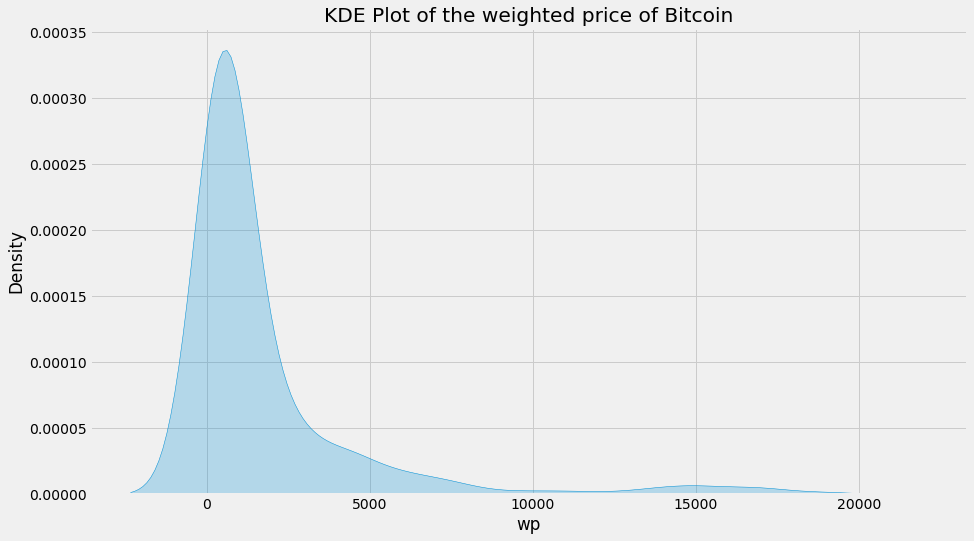

In [26]:
plt.figure(figsize=(14, 8))
sns.kdeplot(data['wp'], shade=True)
plt.title("KDE Plot of the weighted price of Bitcoin")
plt.show()

             ts        wp        hi        lo      open     close
ts     1.000000  0.653069  0.647842  0.659117  0.651009  0.652228
wp     0.653069  1.000000  0.998900  0.998947  0.998828  0.999336
hi     0.647842  0.998900  1.000000  0.996535  0.997239  0.999247
lo     0.659117  0.998947  0.996535  1.000000  0.997598  0.998290
open   0.651009  0.998828  0.997239  0.997598  1.000000  0.997208
close  0.652228  0.999336  0.999247  0.998290  0.997208  1.000000


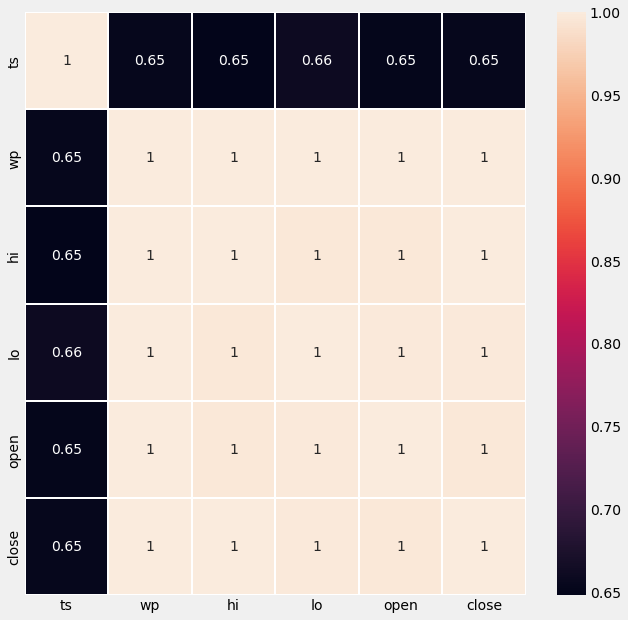

In [27]:
#checking the correlation of the features

corr = data.corr()
print(corr)

plt.subplots(figsize= (10,10))
sns.heatmap(data = corr, annot = True , linewidths = 2)

plt.show()

In [28]:
data_gr = data.groupby(data['date'].dt.strftime('%B'))[['open','close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
data_gr = data_gr.reindex(new_order, axis=0)

In [29]:
names = cycle(['Bitcoin Open Price','Bitcoin Close Price'])

fig = px.line(data, x=data.date, y=[data['open'], data['close']])
fig.update_layout(title_text='Bitcoin price analysis chart over the years',
                        xaxis_title="Date",
                        yaxis_title="Bitcoin Values",
                        font_size=15, font_color='black', 
                        legend_title_text='Bitcoin Parameters')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

In [30]:
names = cycle(['Bitcoin High Price','Bitcoin Low Price'])

fig = px.line(data, x=data.date, y=[data['hi'], data['lo']])
fig.update_layout(title_text='Bitcoin price analysis chart over the years',
                        xaxis_title="Date",
                        yaxis_title="Bitcoin Values",
                        font_size=15, font_color='black', 
                        legend_title_text='Bitcoin Parameters')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

In [131]:
names = cycle(['Bitcoin Open Price','Bitcoin Close Price','Bitcoin High Price','Bitcoin Low Price'])

fig = px.line(data, x=data.date, y=data['close'],
             labels={'Date': 'Date','value':'Bitcoin value'})
fig.update_layout(title_text='Bitcoin closing price analysis chart over the years',
                        xaxis_title="Date",
                        yaxis_title="Bitcoin Closing Price",
                        font_size=15, font_color='black', 
                        legend_title_text='Bitcoin Parameters')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

## Splitting the dataset

Here, we will split the data such that `seasonality` is conserved.

In [32]:
df_train = data[data.date < "2017"]
df_valid = data[data.date >= "2017"]

print('train shape :', df_train.shape)
print('validation shape :', df_valid.shape)

train shape : (467, 7)
validation shape : (282, 7)


In [33]:
exogenous_features = ['wp', 'hi', 'lo','open']

# `ARIMA`

In [34]:
model_arima = pm.auto_arima(df_train.close, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model_arima.fit(df_train.close, exogenous=df_train[exogenous_features])

forecast = model_arima.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2967.489, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2961.318, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2963.852, Time=0.35 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2964.629, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2964.967, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2965.387, Time=0.50 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 2.312 seconds


In [35]:
names = cycle(['close','Forecast_ARIMAX'])

fig = px.line(df_valid, x=df_valid.date, y=[df_valid['close'], df_valid['Forecast_ARIMAX']])
fig.update_layout(title_text='Bitcoin price prediction',
                        xaxis_title="Date",
                        yaxis_title="Bitcoin Values",
                        font_size=15, font_color='black', 
                        legend_title_text='Bitcoin Parameters')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

In [36]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.close, df_valid.Forecast_ARIMAX)))

print("MAE of Auto ARIMAX:", mean_absolute_error(df_valid.close, df_valid.Forecast_ARIMAX))

RMSE of Auto ARIMAX: 120.45925652599524

MAE of Auto ARIMAX: 62.952765269296


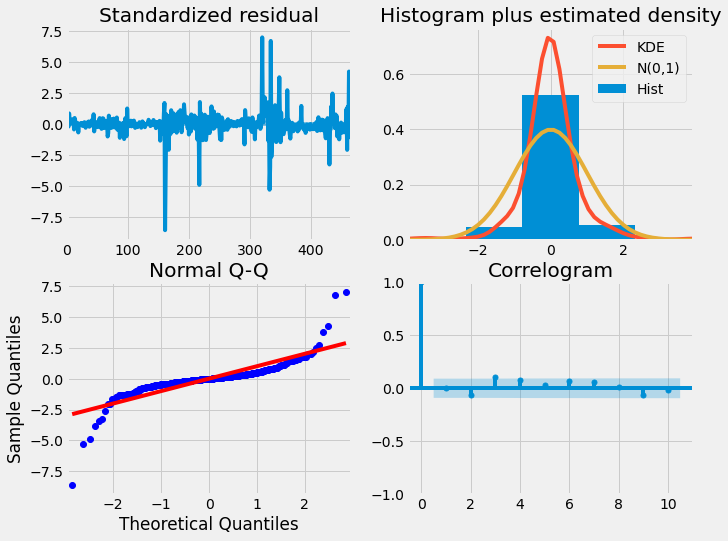

In [37]:
model_arima.plot_diagnostics(figsize=(10, 8))
plt.show()

# `XGBoost`

In [38]:
X_train, y_train = df_train[exogenous_features], df_train.close
X_test, y_test = df_valid[exogenous_features], df_valid.close

In [39]:
xgb_reg = xgb.XGBRegressor()

In [40]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "max_depth"        : [1, 3, 4, 5, 6, 7],
 "n_estimators"     : [int(x) for x in np.linspace(start=100, stop=2000, num=10)],
 "min_child_weight" : [int(x) for x in np.arange(3, 15, 1)],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "subsample"        : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bytree" : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bylevel": [0.5, 0.6, 0.7, 0.8, 0.9, 1],  
 
}

In [41]:
model_xgb  = RandomizedSearchCV(    
                xgb_reg,
                param_distributions=params,
                n_iter=10,
                n_jobs=-1,
                cv=5,
                verbose=3,
)

In [42]:
model_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                                              0.8, 0.9, 1],
                                        'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                  

In [43]:
print(f"XGBoost Model Best Score : {model_xgb.best_score_}")
print(f"XGBoost Model Best Parameters : {model_xgb.best_estimator_.get_params()}")

XGBoost Model Best Score : 0.8884241876345156
XGBoost Model Best Parameters : {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.9, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'enable_categorical': False, 'gamma': 0.6, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.05, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 8, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 944, 'n_jobs': 16, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


In [44]:
model_xgb.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0.6, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=8, missing=nan,
             monotone_constraints='()', n_estimators=944, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [45]:
df_valid['Forecast_XGBoost'] = model_xgb.predict(X_test)

In [46]:
names = cycle(['close','Forecast_XGB in training Data'])

fig = px.line(df_valid, x=df_valid.date, y=[df_valid['close'], df_valid['Forecast_ARIMAX']])
fig.update_layout(title_text='Bitcoin price prediction',
                        xaxis_title="Date",
                        yaxis_title="Bitcoin Values",
                        font_size=15, font_color='black', 
                        legend_title_text='Bitcoin Parameters')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

In [49]:
df_train['Forecast_XGB'] = model_xgb.predict(X_train)

In [51]:
train_mae = mean_absolute_error(df_train['close'], df_train['Forecast_XGB'])
train_rmse = np.sqrt(mean_squared_error(df_train['close'], df_train['Forecast_XGB']))
train_r2 = r2_score(df_train['close'], df_train['Forecast_XGB'])

print(f"train MAE : {train_mae}")
print(f"train RMSE : {train_rmse}")
print(f"train R2 : {train_r2}")

train MAE : 1.328749771281535
train RMSE : 5.0543938077989985
train R2 : 0.9992247598379441


In [52]:
test_mae = mean_absolute_error(df_valid['close'], df_valid['Forecast_XGBoost'])
test_rmse = np.sqrt(mean_squared_error(df_valid['close'], df_valid['Forecast_XGBoost']))
test_r2 = r2_score(df_valid['close'], df_valid['Forecast_XGBoost'])

print(f"test MAE : {test_mae}")
print(f"test RMSE : {test_rmse}")
print(f"test R2 : {test_r2}")

test MAE : 3306.6988914717003
test RMSE : 5437.928372948559
test R2 : -0.584777893790432


## Comparing the two models

In [53]:
names = cycle(['close','Forecast_ARIMAX', 'Forecast_XGBoost'])
fig = px.line(df_valid, x=df_valid.date, y=[df_valid['close'], df_valid['Forecast_ARIMAX'], df_valid['Forecast_XGBoost']])
fig.update_layout(title_text='Bitcoin price prediction comparing for ARIMA & XGBoost',
                        xaxis_title="Date",
                        yaxis_title="Bitcoin Values",
                        font_size=15, font_color='black', 
                        legend_title_text='Bitcoin Parameters')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

Here, clearly the XGBoost is not working well!!

## LSTM

# `scaling` of the dataset

In [54]:
scaler=MinMaxScaler()  
X_train=scaler.fit_transform((X_train))
print(X_train.shape)

(467, 4)


In [55]:
x_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)

In [56]:
x_train.shape

(467, 4, 1)

In [57]:
model=Sequential()

model.add(LSTM(10,input_shape=(x_train.shape[1], x_train.shape[2]),activation="LeakyReLU"))

model.add(Dense(5))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="Adam")

In [58]:
history = model.fit(x_train,y_train,validation_data=(X_test,y_test),epochs=1000,batch_size=25,verbose=1)

Epoch 1/1000
19/19 [==============================] - 1s 10ms/step - loss: 226868.9062 - val_loss: 35903812.0000
Epoch 2/1000
19/19 [==============================] - 0s 3ms/step - loss: 226765.6875 - val_loss: 34605028.0000
Epoch 3/1000
19/19 [==============================] - 0s 2ms/step - loss: 226640.3906 - val_loss: 15609727.0000
Epoch 4/1000
19/19 [==============================] - 0s 2ms/step - loss: 226461.3281 - val_loss: 2421884.0000
Epoch 5/1000
19/19 [==============================] - 0s 3ms/step - loss: 226190.0625 - val_loss: 7474533.0000
Epoch 6/1000
19/19 [==============================] - 0s 2ms/step - loss: 225766.9688 - val_loss: 165588016.0000
Epoch 7/1000
19/19 [==============================] - 0s 2ms/step - loss: 225047.2969 - val_loss: 1596851328.0000
Epoch 8/1000
19/19 [==============================] - 0s 2ms/step - loss: 223674.7969 - val_loss: 6746168320.0000
Epoch 9/1000
19/19 [==============================] - 0s 2ms/step - loss: 220804.0469 - val_loss: 22

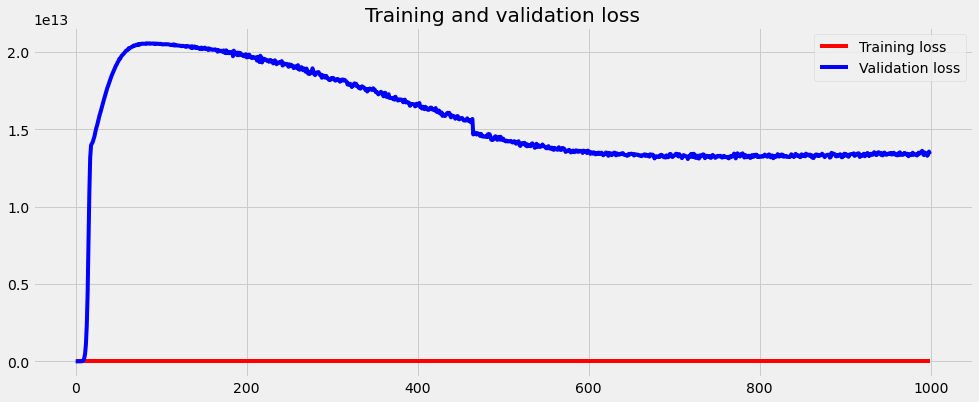

In [59]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))
plt.figure(figsize=(15, 6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)


plt.show()

In [60]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(x_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

((467, 1), (282, 1))

In [63]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,train_predict)))
print("Train data MSE: ", mean_squared_error(y_train,train_predict))
print("Train data MAE: ", mean_absolute_error(y_train,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,test_predict)))
print("Test data MSE: ", mean_squared_error(y_test,test_predict))
print("Test data MAE: ", mean_absolute_error(y_test,test_predict))

Train data RMSE:  7.409199631113801
Train data MSE:  54.896239173696884
Train data MAE:  4.144708195753732
-------------------------------------------------------------------------------------
Test data RMSE:  3662615.5094810575
Test data MSE:  13414752370291.186
Test data MAE:  2560311.6276906026


# Model Selection and Prediction

Hence, By comparing the above models and its evaluation we can conclude that the best model for our dataset will be ARIMA.
We will use the model to predict the `close` price of the given dataset `test`.

In [120]:
test.shape

(250, 6)

In [121]:
test_copy = test.drop(['date', 'ts'], axis=1)

In [122]:
test_copy

,wp,hi,lo,open
86,224.970863,230.08,220.46,229.45
124,225.063422,227.45,223.45,224.03
64,236.029556,238.60,232.78,235.89
236,232.433247,236.93,230.12,235.95
96,229.581977,233.67,226.83,231.51
...,...,...,...,...
113,16345.108730,17364.57,15151.00,16496.90
208,13914.686881,15974.95,10400.00,15758.80
88,13897.409572,15275.00,13005.00,13480.00
147,15796.596968,17178.00,14819.78,15145.00


In [123]:
y_Pred = model_arima.predict(len(test_copy),test_copy)

In [124]:
y_Pred.shape

(250,)

In [125]:
test_label=pd.DataFrame(y_Pred,columns=["close"])

In [129]:
test['close'] = test_label['close']

In [127]:
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d')
test = test.sort_values(by="date")
test

,date,ts,wp,hi,lo,open,close
86,2015-04-17,1.429229e+09,224.970863,230.08,220.46,229.45,435.153755
124,2015-04-20,1.429488e+09,225.063422,227.45,223.45,224.03,612.552094
64,2015-04-22,1.429661e+09,236.029556,238.60,232.78,235.89,375.040385
236,2015-04-24,1.429834e+09,232.433247,236.93,230.12,235.95,8226.610133
96,2015-04-25,1.429920e+09,229.581977,233.67,226.83,231.51,584.825910
...,...,...,...,...,...,...,...
113,2017-12-21,1.513814e+09,16345.108730,17364.57,15151.00,16496.90,614.487629
208,2017-12-22,1.513901e+09,13914.686881,15974.95,10400.00,15758.80,2770.802842
88,2018-01-02,1.514851e+09,13897.409572,15275.00,13005.00,13480.00,450.724845
147,2018-01-05,1.515110e+09,15796.596968,17178.00,14819.78,15145.00,741.697836


In [132]:
names = cycle(['Bitcoin Open Price','Bitcoin Predicted Close Price'])

fig = px.line(test, x=test.date, y=[test['open'], test['close']],
             labels={'Date': 'Date','value':'Bitcoin value'})
fig.update_layout(title_text='Bitcoin closing price prediction',
                        xaxis_title="Date",
                        yaxis_title="Bitcoin Closing Price",
                        font_size=15, font_color='black', 
                        legend_title_text='Bitcoin Parameters')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()